In [1]:
import numpy as np
import matplotlib.pyplot as plt

from imripy import merger_system as ms
from imripy import halo
from imripy import inspiral
from imripy import waveform
from imripy import detector

In [2]:
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 1e1 * ms.solar_mass_to_pc
D = 5e8

sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)

In [3]:
inspiral.Classic.ln_Lambda=10.
rho_spike = 226 * ms.solar_mass_to_pc
r_spike = 0.54
e0 = 0.6
a0 = 200./(1.-e0**2) * sp_0.m1
afin = 1. * sp_0.r_isco()


sp_1 = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, 7./3.), D)
sp_2 = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, 2.),    D)
sp_3 = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, 1.5),   D)

t_0, a_0, e_0, m_0 = inspiral.Classic.evolve_elliptic_binary(sp_0, a0, e0, afin, accretion=True, verbose=False)
t_1, a_1, e_1, m_1 = inspiral.Classic.evolve_elliptic_binary(sp_1, a0, e0, afin, accretion=True, verbose=False)
t_2, a_2, e_2, m_2 = inspiral.Classic.evolve_elliptic_binary(sp_2, a0, e0, afin, accretion=True, verbose=False)
t_3, a_3, e_3, m_3 = inspiral.Classic.evolve_elliptic_binary(sp_3, a0, e0, afin, accretion=True, verbose=False)

print(t_1[-1])

0.07208250075941314


Text(0, 0.5, '$\\Delta m/m$')

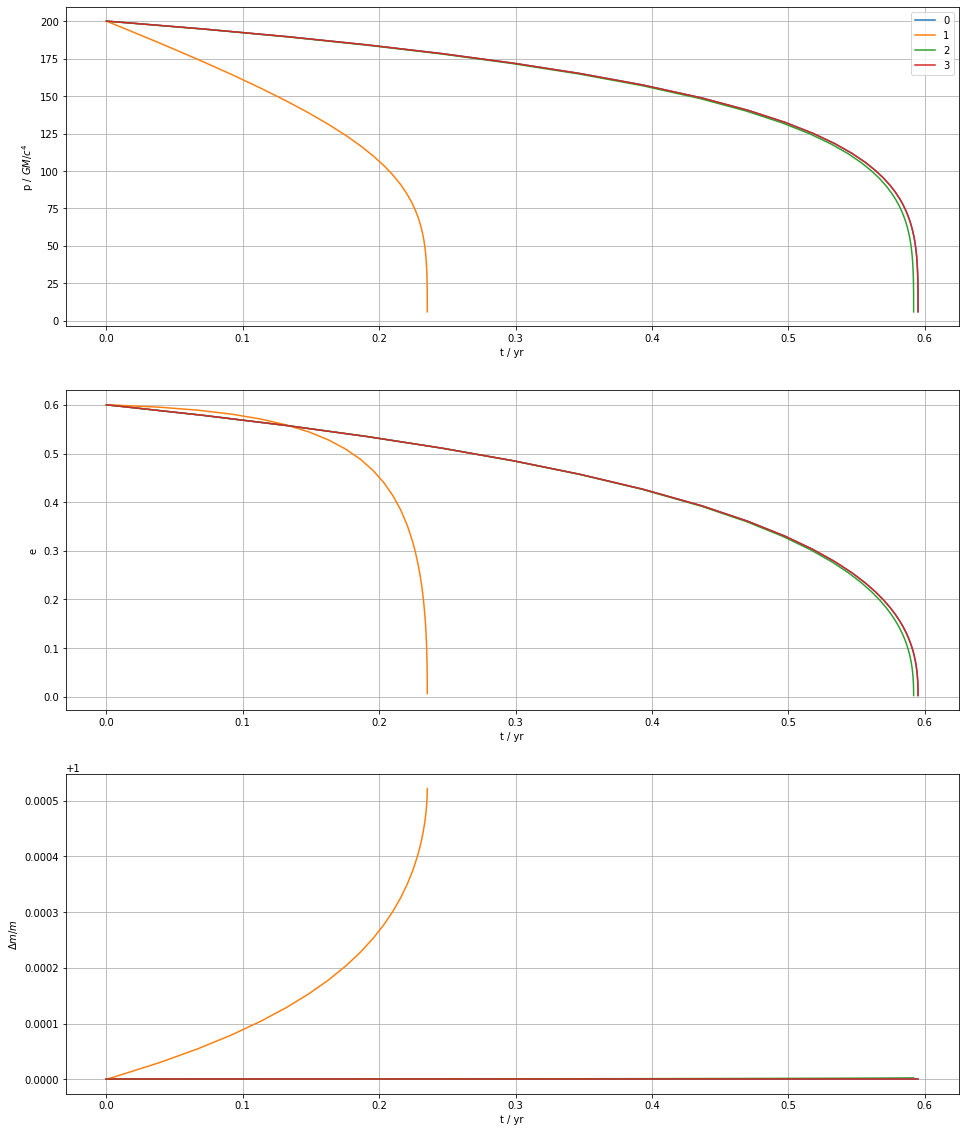

In [4]:
fig, (ax_p, ax_e, ax_m) = plt.subplots(3, 1, figsize=(16,20))
ax_p.plot(t_0/ms.year_to_pc, a_0*(1.-e_0**2)/sp_0.m1, label='0')
ax_p.plot(t_1/ms.year_to_pc, a_1*(1.-e_1**2)/sp_1.m1, label='1')
ax_p.plot(t_2/ms.year_to_pc, a_2*(1.-e_2**2)/sp_2.m1, label='2')
ax_p.plot(t_3/ms.year_to_pc, a_3*(1.-e_3**2)/sp_3.m1, label='3')

ax_e.plot(t_0/ms.year_to_pc, e_0, label='0')
ax_e.plot(t_1/ms.year_to_pc, e_1, label='1')
ax_e.plot(t_2/ms.year_to_pc, e_2, label='2')
ax_e.plot(t_3/ms.year_to_pc, e_3, label='3')

ax_m.plot(t_0/ms.year_to_pc, m_0/m2, label='0')
ax_m.plot(t_1/ms.year_to_pc, m_1/m2, label='1')
ax_m.plot(t_2/ms.year_to_pc, m_2/m2, label='2')
ax_m.plot(t_3/ms.year_to_pc, m_3/m2, label='3')

ax_p.grid(); ax_p.set_xlabel('t / yr'); ax_p.set_ylabel(r'p / $GM/c^4$')
ax_p.legend();
ax_e.grid(); ax_e.set_xlabel('t / yr'); ax_e.set_ylabel('e')  
ax_m.grid(); ax_m.set_xlabel('t / yr'); ax_m.set_ylabel(r'$\Delta m/m$') 

In [5]:
def plotGWspectrum(sp, t, a, e, ax_f, ax_Q=None, n_comp=20, n_disp = 5):
    wfs = [waveform.h_n(n, sp, t, a, e, acc=1e-13) for n in range(1, n_comp+1)]
    for i in range( min(len(wfs), n_disp)):
        ax_f.loglog(wfs[i][0]/ms.hz_to_invpc, np.abs(wfs[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

    f_gw = np.geomspace(np.min(wfs[0][0]), np.max(wfs[n_disp][0]), 5000)

    h_plus_tot = np.sum([ np.interp(f_gw, wf[0], wf[1], left=0., right=0.) * np.exp(1.j * np.interp(f_gw, wf[0], wf[3], left=0., right=0.)) for wf in wfs ],  axis=0)
    h_cross_tot = np.sum([ np.interp(f_gw, wf[0], wf[2], left=0., right=0.) * np.exp(1.j * np.interp(f_gw, wf[0], wf[3], left=0., right=0.)) for wf in wfs ],  axis=0)
    ax_f.plot(f_gw/ms.hz_to_invpc, np.abs(h_plus_tot), label=r"$|h^{SPA}_+|$")

    if not ax_Q is None:
        t_plot = np.linspace(np.min(t) if t[0] > 0. else t[1]*1e-1, np.max(t), 400)
        if ax_Q.get_yscale() == 'log':
            f_plot = np.geomspace(np.min(f_gw), np.max(f_gw)/1e3, 400)
        else:
            f_plot = np.linspace(np.min(f_gw), np.max(f_gw)/1e2, 400)
        t_plot, f_plot = np.meshgrid(t_plot, f_plot)

        h_plus_plot = np.zeros(shape=np.shape(t_plot)); h_cross_plot = np.zeros(shape=np.shape(t_plot))
        for i in range(len(t_plot[0])):
            for wf in wfs:
                f = np.interp(t_plot[0, i], t, wf[0], left=0., right=0.)
                index_f = (np.abs(f_plot[:, i] - f)).argmin()
                h_plus_plot[index_f, i] = np.abs(np.interp(f_plot[index_f, i], wf[0], wf[1]))
                h_cross_plot[index_f, i] = np.abs(np.interp(f_plot[index_f, i], wf[0], wf[2]))

        h_plus_plot = h_plus_plot/np.max(h_plus_plot);  h_cross_plot = h_cross_plot/np.max(h_cross_plot)
        return ax_Q.contourf( t_plot/ms.year_to_pc, f_plot/ms.hz_to_invpc, h_plus_plot, cmap=plt.get_cmap("YlOrRd"))
        #ax_Q.contourf( t_plot/ms.s_to_pc, f_plot/ms.hz_to_invpc, h_cross_plot)



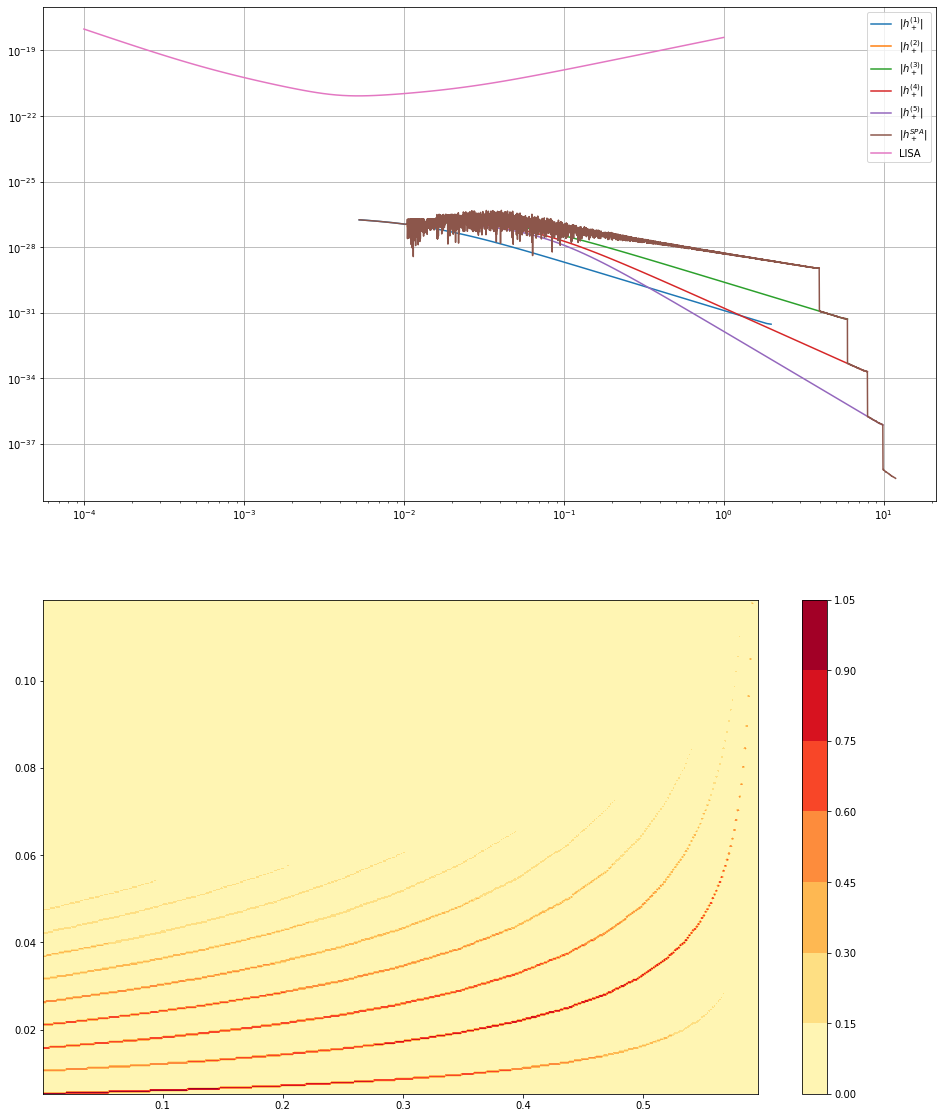

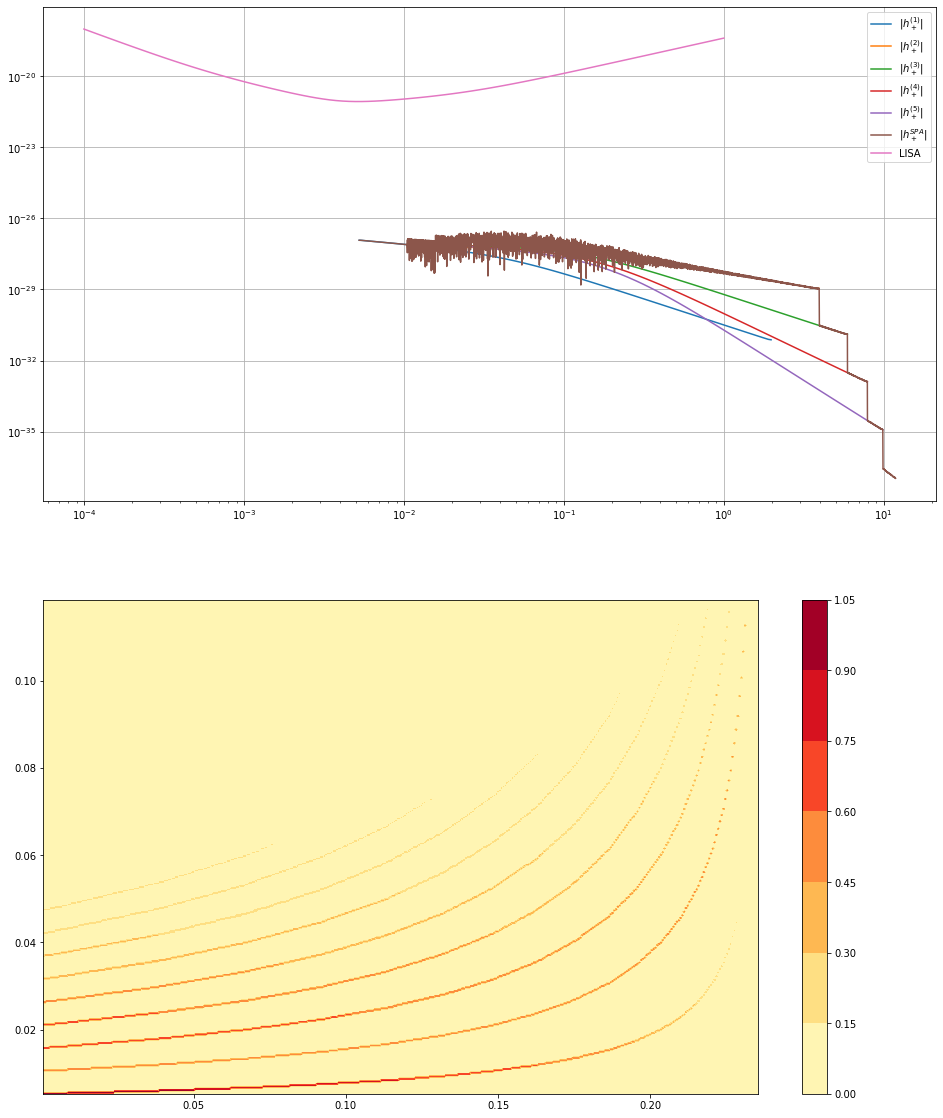

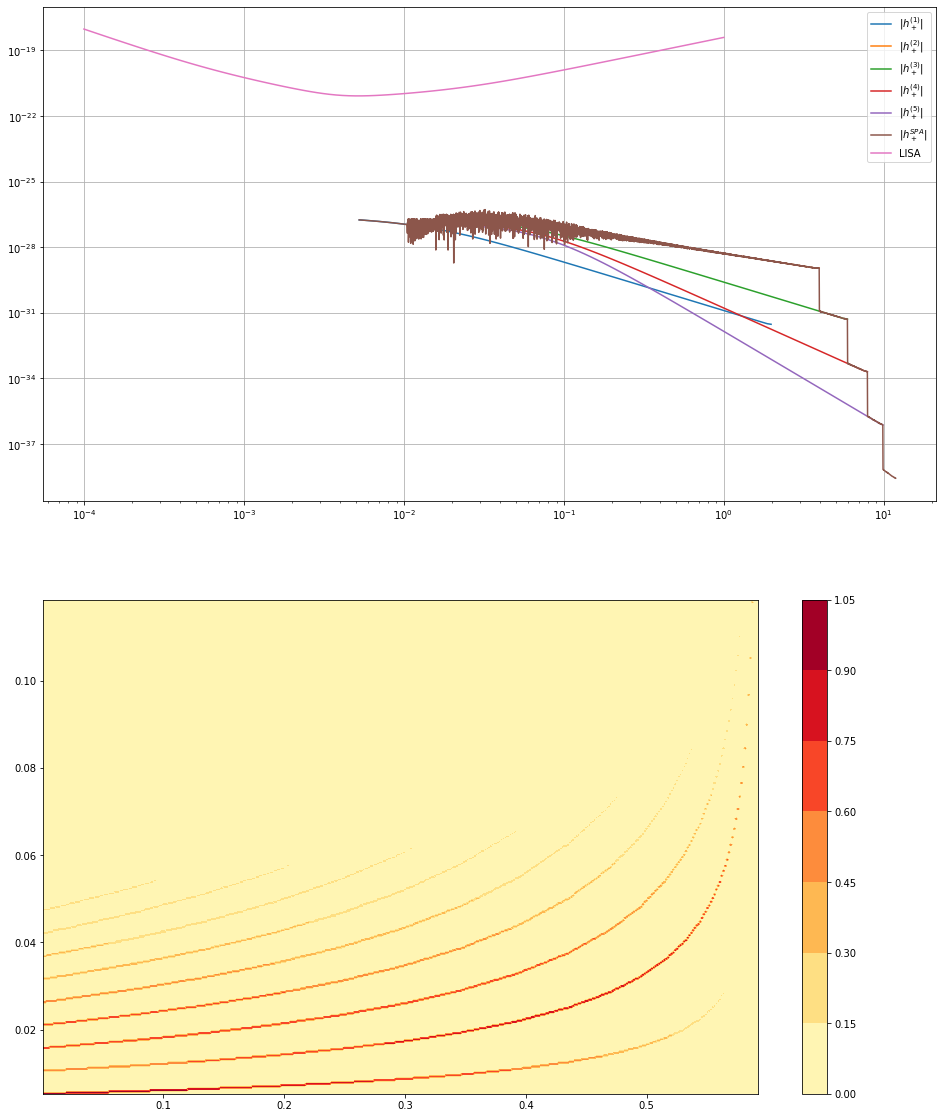

In [6]:
fig, (ax_f, ax_Q) = plt.subplots(2, 1, figsize=(16,20))
mappable = plotGWspectrum(sp_0, t_0, a_0, e_0, ax_f, ax_Q=ax_Q)
f = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
ax_f.plot(f/ms.hz_to_invpc, detector.Lisa().NoiseStrain(f), label='LISA')
ax_f.grid(); ax_f.legend()
fig.colorbar(mappable)

fig, (ax_f, ax_Q) = plt.subplots(2, 1, figsize=(16,20))
mappable = plotGWspectrum(sp_1, t_1, a_1, e_1, ax_f, ax_Q=ax_Q)
f = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
ax_f.plot(f/ms.hz_to_invpc, detector.Lisa().NoiseStrain(f), label='LISA')
ax_f.grid(); ax_f.legend()
fig.colorbar(mappable)

fig, (ax_f, ax_Q) = plt.subplots(2, 1, figsize=(16,20))
mappable = plotGWspectrum(sp_2, t_2, a_2, e_2, ax_f, ax_Q=ax_Q)
f = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
ax_f.plot(f/ms.hz_to_invpc, detector.Lisa().NoiseStrain(f), label='LISA')
ax_f.grid(); ax_f.legend()
fig.colorbar(mappable)

In [10]:
a0 = 1e5/(1.-e0**2) * sp_0.m1
afin = 1. * sp_0.r_isco()

print("0...")
t_0, a_0, e_0, m_0 = inspiral.Classic.evolve_elliptic_binary(sp_0, a0, e0, afin, accretion=True, verbose=False)
print("1...")
t_1, a_1, e_1, m_1 = inspiral.Classic.evolve_elliptic_binary(sp_1, a0, e0, afin, t_fin = t_0[-1]/1e7, accretion=True, verbose=False)
print("2...")
t_2, a_2, e_2, m_2 = inspiral.Classic.evolve_elliptic_binary(sp_2, a0, e0, afin, t_fin = t_0[-1]/1e6, accretion=True, verbose=False)
print("3...")
t_3, a_3, e_3, m_3 = inspiral.Classic.evolve_elliptic_binary(sp_3, a0, e0, afin, t_fin = t_0[-1]/1e4, accretion=True, verbose=False)

0...
1...


/media/data/Documents/PhD/DM-density-spikes-GWs-BH-shadows/src/imripy/inspiral.py:274: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total() * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


2...
3...


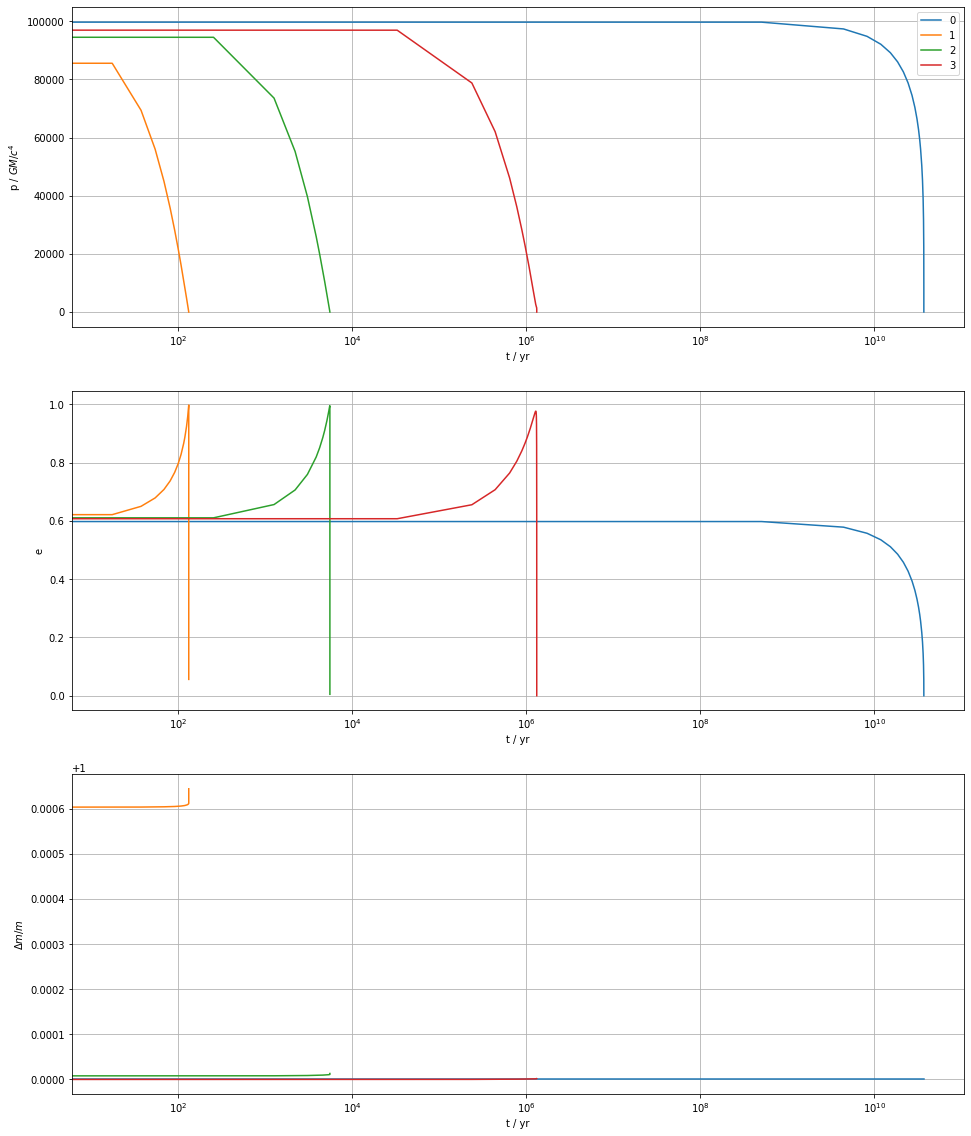

In [11]:
fig, (ax_p, ax_e, ax_m) = plt.subplots(3, 1, figsize=(16,20))
ax_p.plot(t_0/ms.year_to_pc, a_0*(1.-e_0**2)/sp_0.m1, label='0')
ax_p.plot(t_1/ms.year_to_pc, a_1*(1.-e_1**2)/sp_1.m1, label='1')
ax_p.plot(t_2/ms.year_to_pc, a_2*(1.-e_2**2)/sp_2.m1, label='2')
ax_p.plot(t_3/ms.year_to_pc, a_3*(1.-e_3**2)/sp_3.m1, label='3')

ax_e.plot(t_0/ms.year_to_pc, e_0, label='0')
ax_e.plot(t_1/ms.year_to_pc, e_1, label='1')
ax_e.plot(t_2/ms.year_to_pc, e_2, label='2')
ax_e.plot(t_3/ms.year_to_pc, e_3, label='3')

ax_m.plot(t_0/ms.year_to_pc, m_0/m2, label='0')
ax_m.plot(t_1/ms.year_to_pc, m_1/m2, label='1')
ax_m.plot(t_2/ms.year_to_pc, m_2/m2, label='2')
ax_m.plot(t_3/ms.year_to_pc, m_3/m2, label='3')

ax_p.grid(); ax_p.set_xlabel('t / yr'); ax_p.set_ylabel(r'p / $GM/c^4$'); ax_p.set_xscale('log')
ax_p.legend();
ax_e.grid(); ax_e.set_xlabel('t / yr'); ax_e.set_ylabel('e')  ; ax_e.set_xscale('log')
ax_m.grid(); ax_m.set_xlabel('t / yr'); ax_m.set_ylabel(r'$\Delta m/m$') ; ax_m.set_xscale('log')